In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyxdf

%matplotlib inline

# Analyze screen flicker delay/jitter

## Load lsl recording

In [28]:
fpath = 'results\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-Default_run-002_eeg.xdf'
fpath = 'results\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-vsync_test_run-001_eeg.xdf'
fpath = 'results\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-vsync_test_run-002_eeg.xdf'
fpath = 'results\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-vsync_test_run-005_eeg.xdf'
fpath = 'results\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-vsync_test_psychopy_run-001_eeg.xdf'
fpath = 'C:/Users/Experiment/Documents/CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-Default_run-001_eeg.xdf'
# fpath = 'C:/Users/Experiment/Documents/CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-Default_run-001_eeg_old1.xdf'
# fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-Default_run-001_eeg.xdf"
fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-slow_erp_test_run-003_eeg.xdf"
fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-pyglet_slow_erp_run-001_eeg.xdf"
fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-pyglet_fast_erp_run-001_eeg.xdf"
fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-new-monitor-test_run-001_eeg.xdf"
fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-new_monitor_test_run-002_eeg.xdf"

fpath = 'D:/Documents/CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-test_run_run-001_eeg.xdf'
fpath = "../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-screen_flip_test_run-001_eeg.xdf"
# "D:\Documents\CurrentStudy\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-test_run_run-001_eeg.xdf"
streams, header = pyxdf.load_xdf(fpath)

for stream in streams:
    print(stream['info']['name'])

['ScreenMarkerStream']
['ScreenSensorStream']


In [29]:
marker_stream = [s for s in streams if s['info']['name'][0] == 'ScreenMarkerStream'][0]
sensor_stream = [s for s in streams if s['info']['name'][0] == 'ScreenSensorStream'][0]

marker_timestamp = marker_stream['time_stamps']
marker_timeseries = marker_stream['time_series'].flatten()
sensor_timestamp = sensor_stream['time_stamps']
sensor_timeseries = sensor_stream['time_series'].flatten()

In [30]:
marker_timeseries

array([200, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110,
       210, 201, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110,
       110, 211, 202, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110,
       110, 110, 212, 203, 110, 110, 110, 110, 110, 110, 110, 110, 110,
       110, 110, 110, 213, 204, 110, 110, 110, 110, 110, 110, 110, 110,
       110, 110, 110, 110, 214, 205, 110, 110, 110, 110, 110, 110, 110,
       110, 110, 110, 110, 110, 215, 206, 110, 110, 110, 110, 110, 110,
       110, 110, 110, 110, 110, 110, 216, 207, 110, 110, 110, 110, 110,
       110, 110, 110, 110, 110, 110, 110, 217,   0], dtype=int16)

## Check if marker is the same as codebook

In [31]:
marker_timestamp.shape
marker_timeseries.shape

(113,)

In [32]:
# CHeck if there are (n_trials * n_flashes) targets
marker_timestamp = marker_timestamp[marker_timeseries == 110]
marker_timeseries = marker_timeseries[marker_timeseries == 110]
marker_timeseries = (marker_timeseries == 110).astype(int)

marker_timeseries.sum() == 8*12


np.True_

## Clip start and end time

In [33]:
sensor_timeseries = sensor_timeseries[(sensor_timestamp > marker_timestamp[0]) & (sensor_timestamp < marker_timestamp[-1] + 0.025)]
sensor_timestamp = sensor_timestamp[(sensor_timestamp > marker_timestamp[0]) & (sensor_timestamp < marker_timestamp[-1] + 0.025)]
print(sensor_timeseries.shape, sensor_timestamp.shape)

%matplotlib qt
plt.plot(marker_timestamp, marker_timeseries, marker='o', label='marker')
plt.plot(sensor_timestamp, sensor_timeseries, marker='x', label='sensor')
plt.legend()
plt.show()


(192,) (192,)


## Filter sensor jitter

In [34]:
df_marker = pd.DataFrame(
    {
        'timestamp': marker_timestamp,
        'value': marker_timeseries
    }
)
df_sensor = pd.DataFrame(
    {
        'timestamp_sensor': sensor_timestamp,
        'value_sensor': sensor_timeseries
    }
)

df_merged = pd.merge_asof(df_marker, df_sensor, left_on='timestamp', right_on='timestamp_sensor', direction='nearest', tolerance=0.01)
print(df_merged.shape)
print(df_merged.head())
print('\n# of NaNs:')
print(df_merged.isna().sum())

(96, 4)
       timestamp  value  timestamp_sensor  value_sensor
0  339931.919845      1     339931.923676             1
1  339932.919870      1     339932.923411             1
2  339933.903234      1     339933.907177             1
3  339934.786591      1     339934.790450             1
4  339935.786614      1     339935.790447             1

# of NaNs:
timestamp           0
value               0
timestamp_sensor    0
value_sensor        0
dtype: int64


In [35]:
%matplotlib qt
plt.plot(marker_timestamp, marker_timeseries, marker='o', label='marker')
plt.plot(sensor_timestamp, sensor_timeseries, marker='x', label='sensor')
plt.plot(df_merged['timestamp_sensor'], df_merged['value_sensor'], marker='x', label='sensor_filtered')
plt.legend()
plt.show()

Mean delay: 0.0037195396216702648
Delay std: 0.0001023726217820233


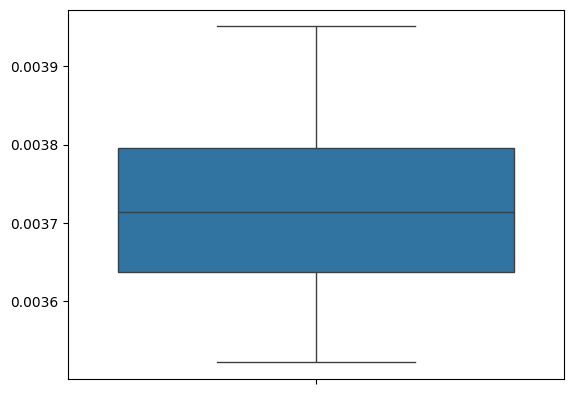

In [36]:
%matplotlib inline
diff = df_merged['timestamp_sensor'] - df_merged['timestamp']
print('Mean delay:', diff.mean())
print('Delay std:', diff.std())
plt.clf()
plt.cla()
sns.boxplot(df_merged['timestamp_sensor'] - df_merged['timestamp'])
plt.show()

In [37]:
# Mean delay: 0.003139559622785386
# Delay std: 0.0004232748245344668

In [38]:
%matplotlib qt
plt.scatter(df_merged['timestamp'], np.zeros_like(df_merged['timestamp']), marker='o', label='sensor_filtered')
plt.scatter(df_merged['timestamp_sensor'], np.zeros_like(df_merged['timestamp_sensor']), marker='x', label='sensor_filtered')
plt.show()

In [39]:
from utils import load_codebooks_block_2

codebook = load_codebooks_block_2()[0, :, 0]

In [40]:
codebook.shape

(48,)

In [41]:
codebook

array([0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.])